<a href="https://colab.research.google.com/github/soyoonjeong/deeplearning_from_scratch/blob/main/ch3_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
%cd /content/drive/MyDrive

/content/drive/MyDrive


# 추론 기반 기법과 신경망 

## 통계 기반 기법의 문제점 

**통계 기반 기법** : 단어의 동시발생 행렬을 만들고 SVD 적용하여 밀집벡터 얻음 <BR>
💣 문제점) 대규모 말뭉치를 다루려면 거대한 동시발생 행렬을 만들어야 하기에 상당한 컴퓨팅 자원을 들여 장시간 계산해야 함 <BR>
=> 학습 데이터 전체를 한꺼번에 처리 (배치 학습) 

⭐ 해결책) **추론 기반 기법**<BR>
말뭉치의 어휘 수가 많아 계산량이 큰 작업을 처리하기 어려운 경우에도 신경망을 학습시킬 수 있음 
=> 학습 데이터의 일부를 순차적으로 학습 (미니배치 학습) <BR>


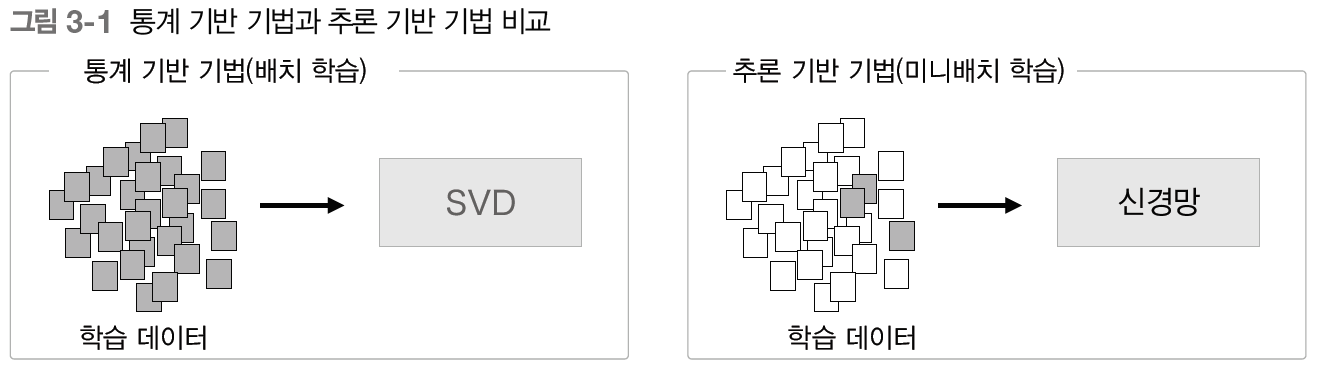

## 추론 기반 기법 개요 

**추론** : 주변 단어(맥락)이 주어졌을 때 사이에 무슨 단어가 들어가는지 추측하는 작업 <BR>
**추론 기반 기법** : 맥락 정보를 입력받아 각 단어의 출현 확률을 출력<BR> 
- 말뭉치를 사용해 모델이 올바른 추측을 내놓도록 학습 -> 단어의 분산 표현 얻기 
- 분포 가설(단어의 의미는 주변 단어에 의해 형성된다) 기초

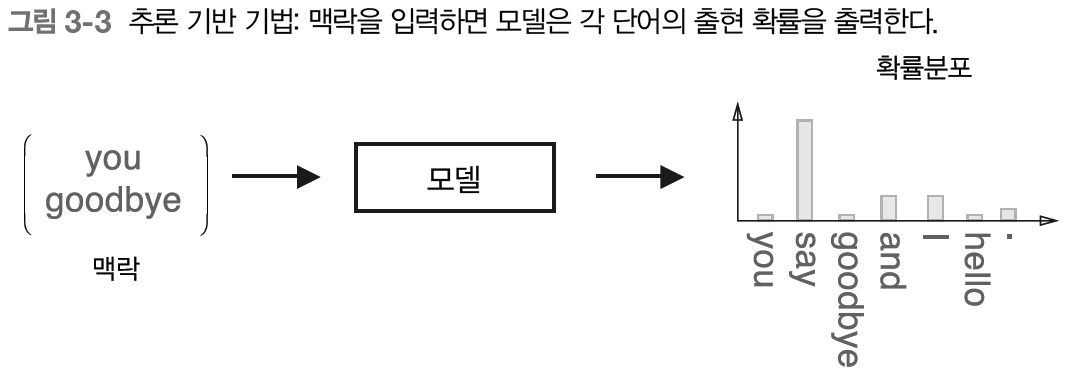

## 신경망에서의 단어 처리 

'단어' -> '고정 길이의 벡터' => **원핫 인코딩** <BR>
: 총 어휘 수만큼의 원소를 갖는 벡터를 준비, 인덱스가 단어 ID와 같은 원소를 1로, 나머지를 0으로 설정  <BR>
=> 단어를 벡터로 나타내어 단어를 신경망으로 처리 가능 

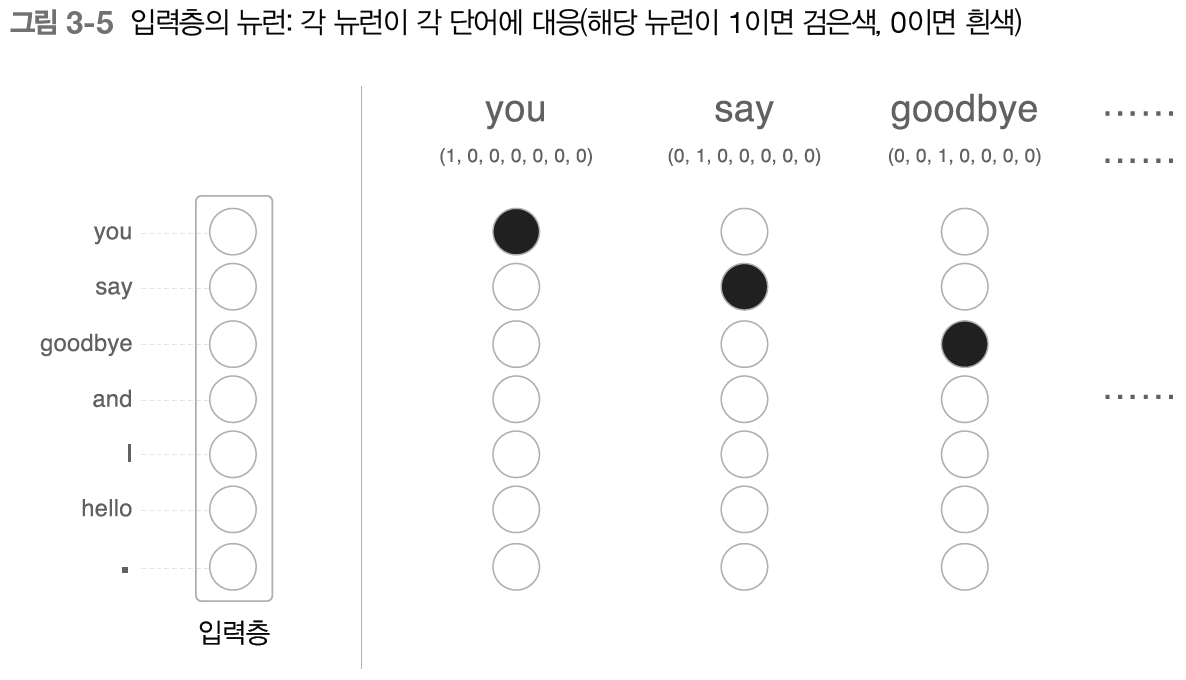

원핫 표현으로 된 단어 하나를 완전연결계층을 통해 변환 <BR>
입력층 뉴런과의 가중합이 은닉층의 뉴런이 됨 (편향 구현 X => 행렬곱만)<BR>
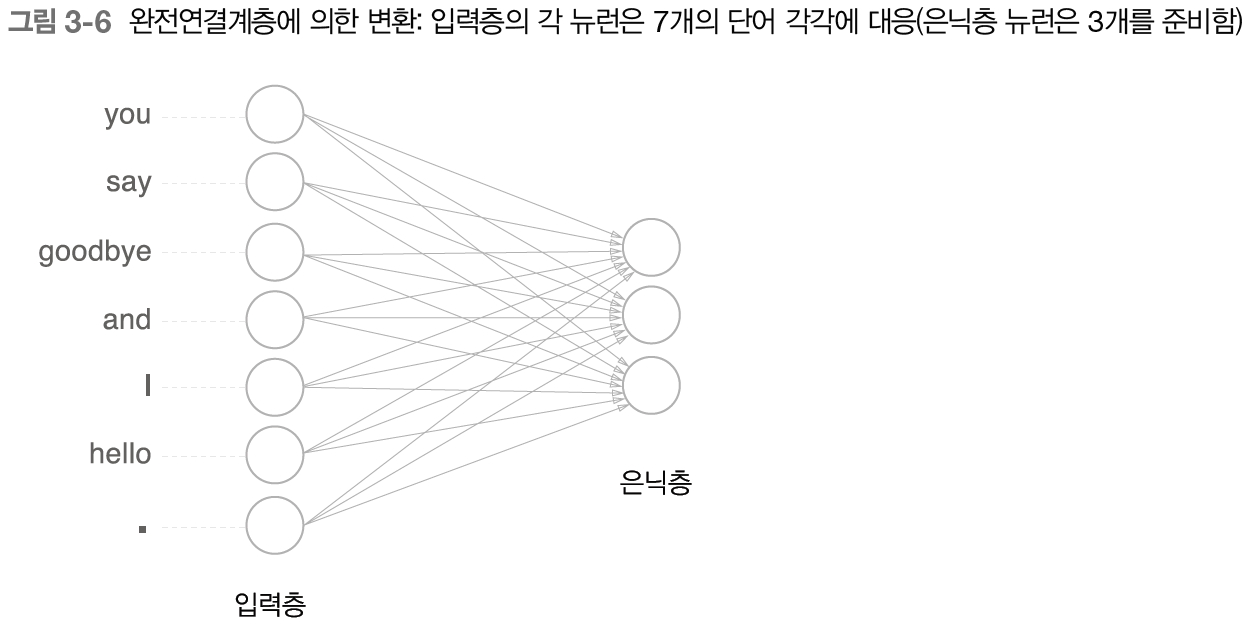

In [ ]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self, x):
        W, = self.params
        out = np.matmul(x, W)
        self.x = x
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        self.grads[0][...] = dW  # 깊은 복사
        return dx

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 1x7
W = np.random.randn(7,3)
layer = MatMul(W)
h  = layer.forward(c)
print(h)

[[-0.53083615  0.79300462  1.56196217]]


# 단순한 word2vec

## CBOW 모델의 추론 처리리

**CBOW 모델** : continuous bag of words <br>
- 맥락으로부터 타깃을 추측하는 용도의 신경망


**뉴런 관점** <br>
- 은닉층의 뉴런은 입력층의 완전연결계층에 의해 변환된 값, 입력층이 여러 개(맥락 단어가 여러 개)라면 전체를 평균 
- 은닉층의 뉴런 수는 입력층의 뉴런 수보다 적어야 함 => 은닉층에 단어 예측에 필요한 정보를 간결하게 담아 밀집벡터 표현을 얻을 수 있음 
- 출력층 뉴런은 각 단어의 점수를 뜻하며 갚이 높을수록 대응 단어의 출현 확률 높아짐 
- 완전연결계층의 **가중치가 단어의 분산 표현**!
- 학습을 진행할수록 맥락에서 출현하는 단어를 잘 추측하는 방향으로 분산 표현들이 갱신 

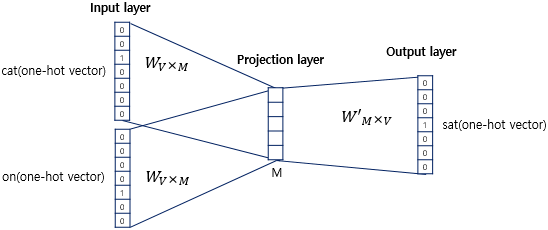

**계층 관점** <br>
2개의 맥락 단어에 의해 2개의 MatMul 계층이 있음 <br>
-> 2개의 계층 출력이 더해지고 0.5가 곱해짐(평균) => 은닉층 뉴런 <br>
-> 은닉층 뉴런에 MatMul 계층이 적용되어 점수 출력  

In [ ]:
c0 = np.array([1, 0, 0, 0, 0, 0, 0])
c1 = np.array([0, 0, 1, 0, 0, 0, 0])

W_in = np.random.randn(7,3)
W_out = np.random.randn(3, 7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = (h0 + h1) * 0.5
s = out_layer.forward(h)

print(s)

[ 3.2771457  -0.84187152 -1.25325857  1.96518919  1.72033301  0.68463579
 -2.57761535]


## CBOW 모델의 학습

- 올바른 예측을 할 수 있도록 가중치를 조정
- 학습 시 사용한 말뭉치로부터 가중치에 단어의 출현 패턴을 파악한 벡터가 학습됨 
- 단어의 분산 표현은 단어의 의미, 문법 면에서 모두 우리의 직관에 부합

소프트맥스 함수를 이용해 점수를 확률로 변환 -> 확률과 정답 레이블로부터 교차 엔트로피 오차 (손실) 구하여 학습 진행 

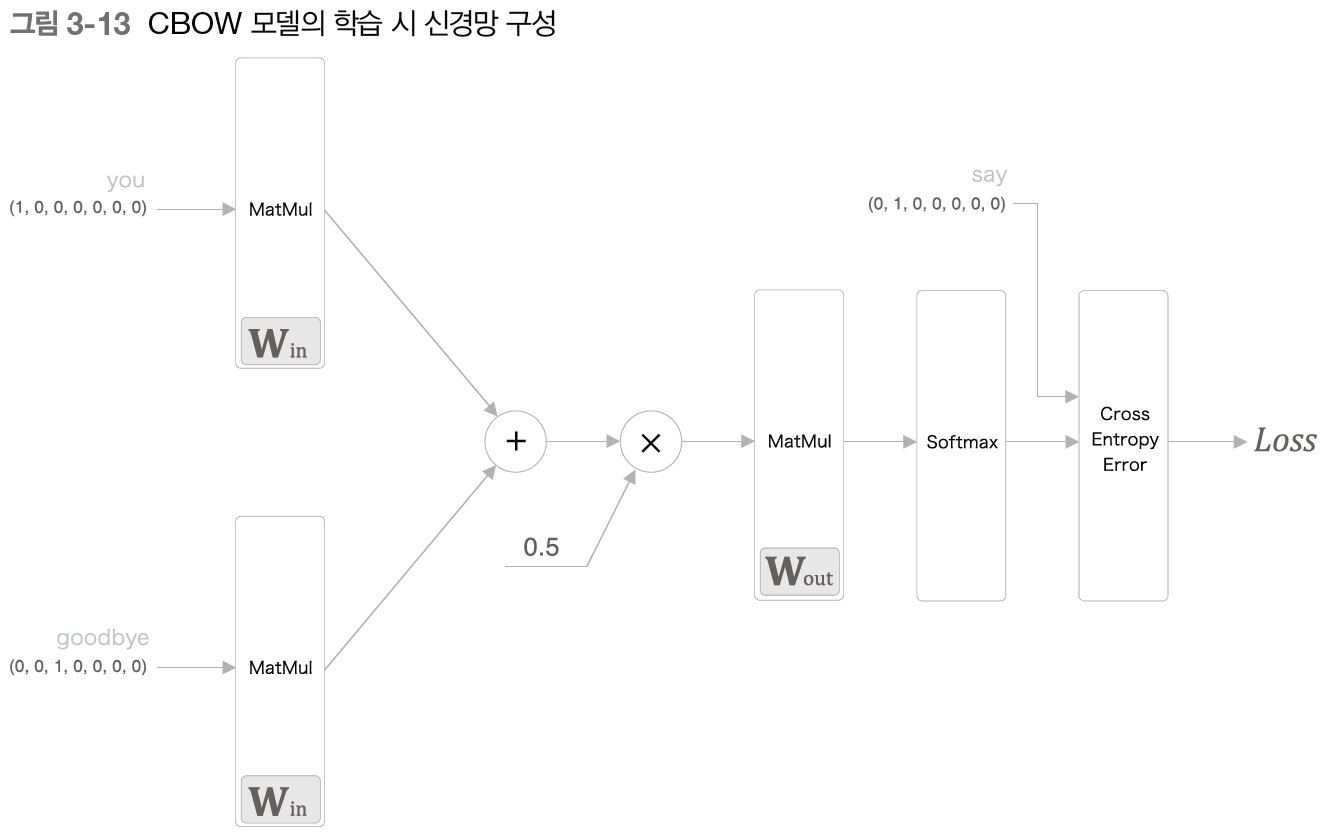

### word2vec의 가중치와 분산 표현

- 입력 측 가중치의 각 행이 각 단어의 분산 표현
- 출력 측 가중치의 각 열이 각 단어의 분산 표현 
- 두 가중치 중 단어의 분산 표현으로 대부분 입력 측의 가중치를 사용함함

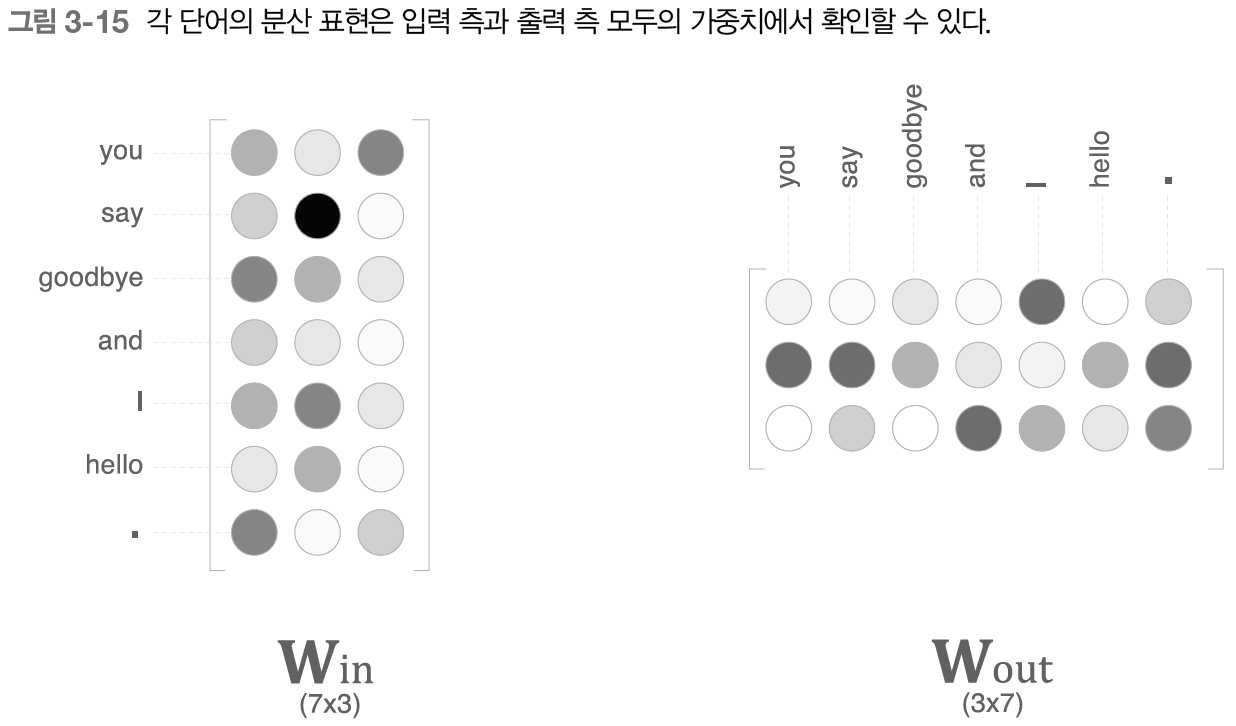

# 학습 데이터 준비

## 맥락과 타깃

**맥락** : 신경망의 입력 <br>
**타깃** : 정답레이블, 맥락에 둘러싸인 중앙의 단어 <br>
=> 신경망에 맥락을 입력했을 때 타깃이 출현할 확률을 높이는 것 

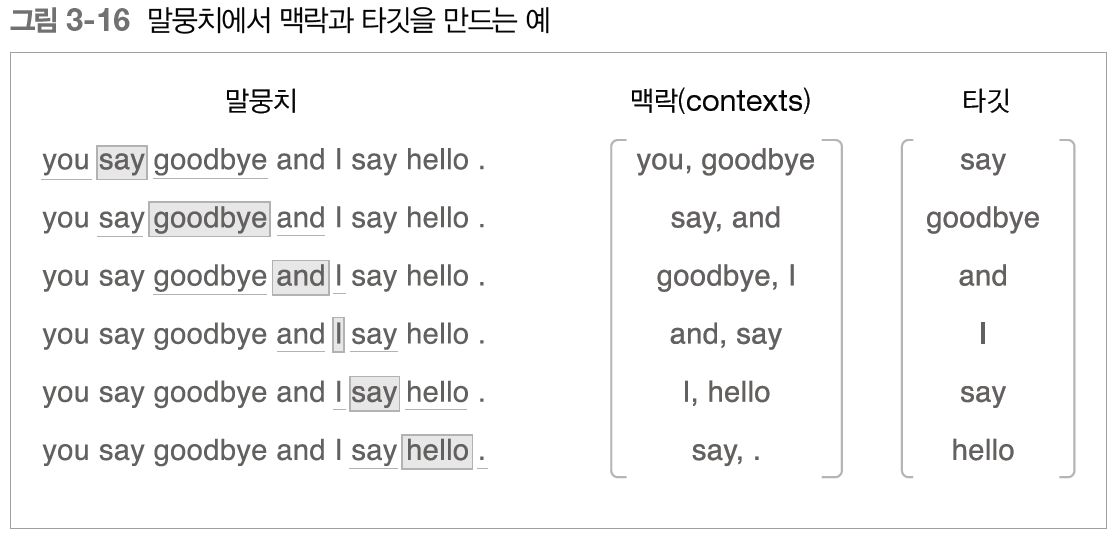

**말뭉치 텍스트를 단어 ID로 변환**

In [ ]:
from common.util import preprocess

text = 'You say goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


**단어 ID 배열인 corpus로부터 맥락과 타깃을 생성**

In [ ]:
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []

  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size+1):
      if t == 0:
        continue
      cs.append(corpus[idx+t])
    contexts.append(cs)

  return np.array(contexts), np.array(target)

In [ ]:
contexts, target = create_contexts_target(corpus, window_size = 1)

print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


## 원핫 표현으로 변환환

**단어 ID를 원핫표현으로 변환**

In [ ]:
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size = 1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# CBOW 모델 구현